In [5]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [7]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [6]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [7]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [4]:
import uuid

In [5]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\cffdbe25-f407-11ee-8666-f85ea0e7ea7c.jpg'

In [5]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

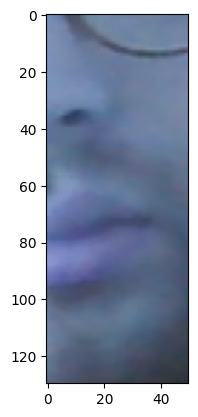

In [6]:
plt.imshow(frame[120:120+250,200:200+250, :])

In [36]:
for i in range(1,8):
    # Load the image
    image = cv2.imread(f'data/positive/{i}.jpg')

    # Resize the image to 250x250 pixels
    resized_image = cv2.resize(image, (250, 250))

    # If you want to convert the image to RGB format
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Save the resized image
    cv2.imwrite(f'{i}.jpg', resized_image_rgb)

In [22]:

anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(350)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(350)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(350)

<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
C:\Users\ghass\AppData\Local\Temp\ipykernel_13580\2202958295.py:1: SyntaxWarning: invalid escape sequence '\*'
  anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(350)
C:\Users\ghass\AppData\Local\Temp\ipykernel_13580\2202958295.py:2: SyntaxWarning: invalid escape sequence '\*'
  positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(350)
C:\Users\ghass\AppData\Local\Temp\ipykernel_13580\2202958295.py:3: SyntaxWarning: invalid escape sequence '\*'
  negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(350)


In [9]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\97474817-f352-11ee-a7f5-f85ea0e7ea7c.jpg'


In [43]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [28]:
example = positive.as_numpy_iterator()
example.next()

b'data\\positive\\50d3d7cb-f353-11ee-8f89-f85ea0e7ea7c.jpg'

In [30]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [31]:
print(len(positives))
samples = data.as_numpy_iterator()

350


In [40]:
example = samples.next()
example

(b'data\\anchor\\01c998ba-f353-11ee-aa3e-f85ea0e7ea7c.jpg',
 b'data\\positive\\9e07159d-f353-11ee-9115-f85ea0e7ea7c.jpg',
 1.0)

In [44]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [45]:
res = preprocess_twin(*example)

1.0


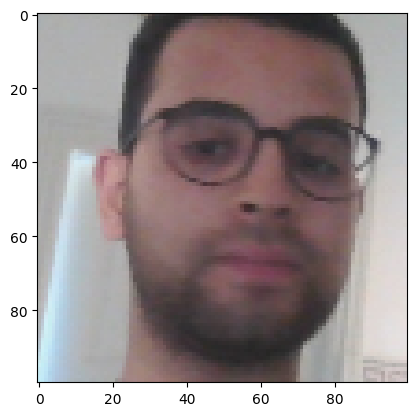

In [46]:
plt.imshow(res[1])
print(res[2])

In [47]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [48]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [49]:
samples = data.as_numpy_iterator()

1.0


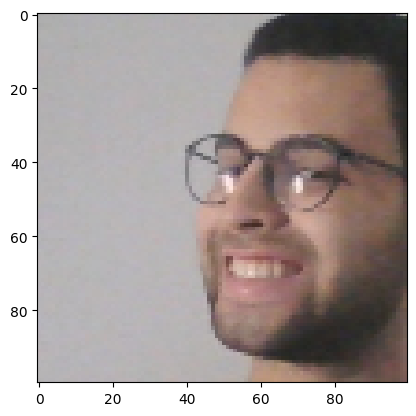

In [58]:
example = samples.next()
print(example[2])
plt.imshow(example[0])

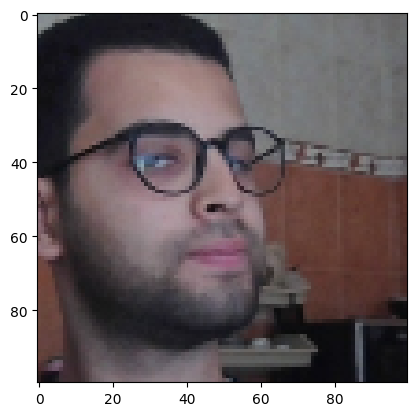

In [59]:
plt.imshow(example[1])

In [60]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [61]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [62]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [63]:
embedding = make_embedding()

In [64]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [66]:
l1 = L1Dist()

In [67]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [68]:
siamese_model = make_siamese_model()

In [33]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(0.0001) # 0.0001

In [35]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [36]:
test_batch = train_data.as_numpy_iterator()

In [37]:
batch_1 = test_batch.next()

In [38]:
batch_1[2]

array([1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.],
      dtype=float32)

In [39]:
X = batch_1[:2]
Y = batch_1[2]

In [40]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [41]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [42]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [43]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [44]:
EPOCHS = 10

In [45]:
train(train_data, EPOCHS)


 Epoch 1/10
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steptep
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━

In [46]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [47]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [48]:
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat ]
print(y_hat)

[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1]


In [49]:
y_true

array([0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
      dtype=float32)

In [50]:
m = Precision()
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

In [51]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

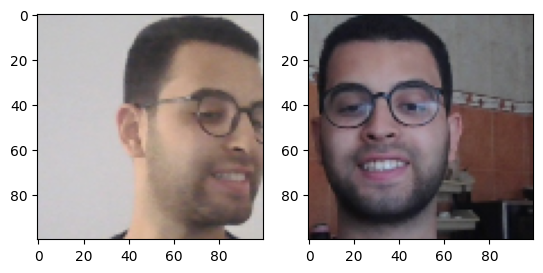

In [52]:
plt.subplot(1, 2, 1)
plt.imshow(test_input[3])
plt.subplot(1, 2, 2)
plt.imshow(test_val[3])
plt.show()

In [58]:
import os

# Check if the file exists
if os.path.exists("model.h5"):
  # Delete the existing file
  os.remove("model.keras")
  print("Existing model.h5 deleted.")

# Now try saving your model
siamese_model.save("model.keras")

In [16]:
tf.keras.models.load_model??

Signature:
tf.keras.models.load_model(
    filepath,
    custom_objects=None,
    compile=True,
    safe_mode=True,
)
Source:   
@keras_export(["keras.saving.load_model", "keras.models.load_model"])
def load_model(filepath, custom_objects=None, compile=True, safe_mode=True):
    """Loads a model saved via `model.save()`.

    Args:
        filepath: `str` or `pathlib.Path` object, path to the saved model file.
        custom_objects: Optional dictionary mapping names
            (strings) to custom classes or functions to be
            considered during deserialization.
        compile: Boolean, whether to compile the model after loading.
        safe_mode: Boolean, whether to disallow unsafe `lambda` deserialization.
            When `safe_mode=False`, loading an object has the potential to
            trigger arbitrary code execution. This argument is only
            applicable to the Keras v3 model format. Defaults to True.

    Returns:
        A Keras model instance. If the orig

In [18]:
model = tf.keras.models.load_model("model.keras" , custom_objects={"L1Dist":L1Dist})

In [53]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [54]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [55]:
np.sum(np.squeeze(results) > 0.9)

NameError: name 'results' is not defined

In [65]:
prediction = model.predict([test_input, test_val])
print(prediction)
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat ]
print(y_hat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[3.2732551e-04]
 [1.3688385e-03]
 [9.3618827e-04]
 [9.9975312e-01]
 [9.9998677e-01]
 [8.9747018e-06]
 [6.5012717e-01]
 [3.7104419e-05]
 [2.7595876e-02]
 [9.9457157e-01]
 [1.9599912e-03]
 [8.1010421e-07]
 [4.0497762e-05]
 [3.3750087e-08]
 [9.9972320e-01]
 [9.9987638e-01]]
[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1]


In [64]:
y_true

array([0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
      dtype=float32)

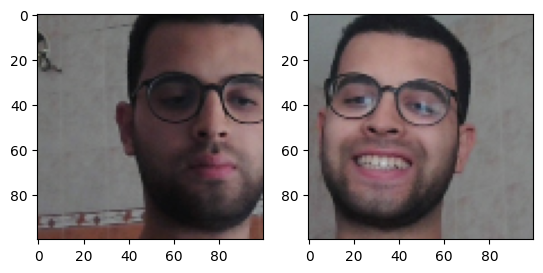

In [66]:
plt.subplot(1, 2, 1)
plt.imshow(test_input[6])
plt.subplot(1, 2, 2)
plt.imshow(test_val[6])
plt.show()